# Actor Critic

**Actor-Critic methods** learn both a policy $\pi(a|s;\theta)$ and a state-value function $v(s;w)$ simultaneously. The policy is referred to as the actor that suggests actions given a state. The estimated value function is referred to as the critic. It evaluates actions taken by the actor based on the given policy. In this exercise, both functions are approximated by feedforward neural networks. 

- The policy network is parametrized by $\theta$ - it takes a state $s$ as input and outputs the probabilities $\pi(a|s;\theta)\ \forall\ a$
- The value network is parametrized by $w$ - it takes a state $s$ as input and outputs a scalar value associated with the state, i.e., $v(s;w)$
- The single step TD error can be defined as follows:
$$\delta_t  = R_{t+1} + \gamma v(s_{t+1};w) - v(s_t;w)$$
- The loss function to be minimized at every step ($L_{tot}^{(t)}$) is a summation of two terms, as follows:
$$L_{tot}^{(t)} = L_{actor}^{(t)} + L_{critic}^{(t)}$$
where,
$$L_{actor}^{(t)} = -\log\pi(a_t|s_t; \theta)\delta_t$$
$$L_{critic}^{(t)} = \delta_t^2$$
- **NOTE: Here, weights of the first two hidden layers are shared by the policy and the value network**
    - First two hidden layer sizes: [1024, 512]
    - Output size of policy network: 2 (Softmax activation)
    - Output size of value network: 1 (Linear activation)

<!-- $$\pi(a|s;\theta) = \phi_{\theta}(a,s)$$ -->

# One Time Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")
actual_root_dir = "/content/drive/MyDrive/rl_pa2/"
root_dir = "/content/pa2"
!ln -s {actual_root_dir} {root_dir}
root_dir = "/content/pa2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/pa2/rl_pa2': File exists


In [ ]:
!python3 -m pip install gymnasium pyvirtualdisplay > /dev/null 2>&1
!python3 -m pip install tensorflow tensorflow_probability > /dev/null
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!python3 -m pip install --upgrade setuptools 2>&1
!python3 -m pip install ez_setup > /dev/null 2>&1
!python3 -m pip install 'gym[atari]' > /dev/null 2>&1
!python3 -m pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!python3 -m pip install 'gym[classic_control]' > /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# AC Code

## Setup

In [ ]:
import datetime
from collections import namedtuple, deque
import random
import numpy as np

import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

twrite = tqdm.write

import gymnasium as gym
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
import tensorflow as tf
import tensorflow_probability as tfp


from PIL import Image
from pyvirtualdisplay import Display

## Initializing Actor-Critic Network

In [ ]:
class ActorCriticModel(tf.keras.Model):
    """
    Defining policy and value networkss
    """

    def __init__(self, action_size, layer_ns):
        super(ActorCriticModel, self).__init__()

        # Hidden Layers
        self.my_layers = [tf.keras.layers.Dense(n, activation="relu") for n in layer_ns]
        
        # Output Layers
        self.pi_out = tf.keras.layers.Dense(action_size, activation="softmax")
        self.v_out = tf.keras.layers.Dense(1)

    def call(self, state):
        """
        Computes policy distribution and state-value for a given state
        """
        out = state
        for layer in self.my_layers:
            out = layer(out)

        pi = self.pi_out(out)
        v = self.v_out(out)

        return pi, v

In [ ]:
class Agent:

    def __init__(
        self, action_size, lr=0.001, gamma=0.99, seed=85, n_s=(1024, 512), h=1
    ):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        assert h == 1
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size, layer_ns=n_s)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        self.seed_str = tfp.util.SeedStream(seed, salt="random_beta")

    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi, _ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample(seed=self.seed_str())

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0, action]) * delta

    def critic_loss(self, delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    @tf.function
    def learn(self, state, action, reward, next_state, done):
        """
        For a given transition (s,a,s',r) update the paramters by computing the
    gradient of the total loss
        """
        with tf.GradientTape(persistent=True) as tape:
            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)

            # $\delta_t  = R_{t+1} + \gamma v(s_{t+1};w) - v(s_t;w)$
            delta = reward + self.gamma * V_s_next - V_s
            loss_a = self.actor_loss(action, pi, delta)
            loss_c = self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(
            zip(gradient, self.ac_model.trainable_variables)
        )

In [ ]:
class nAgent:
    """
    Agent class
    """

    def __init__(
        self, action_size, lr=0.001, gamma=0.99, seed=85, n_s=(1024, 512), h=10
    ):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        # assert h != 1
        self.h = h
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size, layer_ns=n_s)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        self.seed_str = tfp.util.SeedStream(seed, salt="random_beta")

        self.history = []

    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi, _ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample(seed=self.seed_str())

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0, action]) * delta

    def critic_loss(self, delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    def learn(self, state, action, reward, next_state, done):
        self.history.append((state, action, reward, next_state))

        while len(self.history) >= self.h:
            self.learn_once(self.history[: self.h])
            del self.history[0]

        if done:
            self.history = []

    # @tf.function
    def learn_once(self, hist):
        with tf.GradientTape(persistent=True) as tape:
            state = hist[0][0]
            action = hist[0][1]
            # reward = None
            next_state = hist[-1][3]

            rewards = 0
            for i in range(self.h):
                rewards += hist[i][2] * self.gamma**i

            pi, V_s = self.ac_model(state)
            _, V_s_next = self.ac_model(next_state)

            V_s = tf.squeeze(V_s)
            V_s_next = tf.squeeze(V_s_next)

            delta = rewards + self.gamma**self.h * V_s_next - V_s
            loss_a = self.actor_loss(action, pi, delta)
            loss_c = self.critic_loss(delta)
            loss_total = loss_a + loss_c

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(
            zip(gradient, self.ac_model.trainable_variables)
        )

In [ ]:
class TAgent:
    """
    Agent class
    """

    def __init__(
        self, action_size, lr=0.001, gamma=0.99, seed=85, n_s=(1024, 512), h=np.inf
    ):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        # assert h != 1
        self.h = h
        self.gamma = gamma
        self.ac_model = ActorCriticModel(action_size=action_size, layer_ns=n_s)
        self.ac_model.compile(tf.keras.optimizers.Adam(learning_rate=lr))
        self.seed_str = tfp.util.SeedStream(seed, salt="random_beta")

        self.history = []

    def sample_action(self, state):
        """
        Given a state, compute the policy distribution over all actions and sample one action
        """
        pi, _ = self.ac_model(state)

        action_probabilities = tfp.distributions.Categorical(probs=pi)
        sample = action_probabilities.sample(seed=self.seed_str())

        return int(sample.numpy()[0])

    def actor_loss(self, action, pi, delta):
        """
        Compute Actor Loss
        """
        return -tf.math.log(pi[0, action]) * delta

    def critic_loss(self, delta):
        """
        Critic loss aims to minimize TD error
        """
        return delta**2

    def learn(self, state, action, reward, next_state, done):
        self.history.append((state, action, reward, next_state))

        # We only actually learn at the end of the ep
        if done:
            self.learn_impl(self.history)
            del self.history
            self.history = []

    # @tf.function
    def learn_impl(self, history):
        with tf.GradientTape(persistent=True) as tape:
            L_ac = 0
            L_cr = 0

            for t in range(len(history)):
                state = history[t][0]
                action = history[t][1]

                rewards = 0.0
                for i in range(len(history) - t):
                    history[t + i][2] * self.gamma**i

                pi, V_s = self.ac_model(state)
                V_s = tf.squeeze(V_s)

                delta = rewards - V_s
                L_ac += self.actor_loss(action, pi, delta)
                L_cr += self.critic_loss(delta)

            loss_total = L_ac + L_cr

        gradient = tape.gradient(loss_total, self.ac_model.trainable_variables)
        self.ac_model.optimizer.apply_gradients(
            zip(gradient, self.ac_model.trainable_variables)
        )

## Runner

In [ ]:
# def run_agent_impl(env_seed, agent_seed, lr=1e-4, n_s=(512, 512, 512)):
def run_agent(params, tt=None, override_to_n=False, ret=False, reset_graph=False):
    AgentImpl = Agent
    if override_to_n or params.h != 1:
        AgentImpl = nAgent
    if params.h == np.inf:
        AgentImpl = TAgent

    lr = params.lr
    env_seed = params.seeds[0]
    agent_seed = params.seeds[1]
    rng = np.random.default_rng(env_seed)
    n_s = params.layer_sizes

    env = gym.make(params.env)

    env.reset(seed=int(rng.random() * 2**16))

    # Initializing Agent
    agent = AgentImpl(
        action_size=env.action_space.n, lr=lr, seed=agent_seed, n_s=n_s, h=params.h
    )

    # Number of episodes
    episodes = params.episodes
    tf.compat.v1.reset_default_graph()

    time_list = []
    steps_list = []
    reward_list = []

    begin_time = datetime.datetime.now()

    # if tt is not None:
    # tt.reset(total=episodes)
    try:
        for ep in trange(1, episodes + 1, desc="Ep", position=1, leave=True):
            # for ep in range(1, episodes + 1):
            # state = env.reset(seed=int(rng.random() * 2**16))[0].reshape(1, -1)
            state = env.reset()[0].reshape(1, -1)
            done = False
            steps = 0
            ep_rew = 0
            while not done:
                steps += 1
                action = agent.sample_action(state)  # Sample Action

                next_state, reward, terminated, truncated, info = env.step(
                    action
                )  # Take action
                if params.env == "CartPole-v1" or params.env == "MountainCar-v0":
                    reward += 1
                done = terminated or truncated
                next_state = next_state.reshape(1, -1)

                ep_rew += reward  # Updating episode reward
                agent.learn(
                    state, action, reward, next_state, done
                )  # Update Parameters

                state = next_state  # Updating State
            reward_list.append(ep_rew)
            steps_list.append(steps)
            time_list.append((datetime.datetime.now() - begin_time).total_seconds())
            if tt is not None:
                tt.update()

            # if reset_graph is not None and ep % reset_graph == 0:
            #     tf.compat.v1.reset_default_graph()

            # if ep % 10 == 0:
            #     avg_rew = np.mean(reward_list[-10:])

            #     twrite(f"Episode {ep} Reward {ep_rew:.2f} Average Reward {avg_rew:.2f}")
            # if ep % 100:
            #     avg_100 = np.mean(reward_list[-100:])

            #     if avg_100 > 195.0:
            #         # twrite(f"Stopped at Episode {ep - 100}")
            #         break

        rn, tn, sn = np.array(reward_list), np.array(time_list), np.array(steps_list)
        write_data(params, rn, tn, sn)

    except KeyboardInterrupt:
        print("Keyboard interrupt!")
        pass
    finally:
        time_taken = datetime.datetime.now() - begin_time
        rn, tn, sn = np.array(reward_list), np.array(time_list), np.array(steps_list)
        if reset_graph:
            tf.keras.backend.clear_session()
        if ret:
            return tn, rn, sn

## Params

In [ ]:
from dataclasses import dataclass
from typing import List, Tuple, Literal


@dataclass
class Params:
    env: Literal["Acrobot-v1", "CartPole-v1", "MountainCar-v0"]
    h: int
    lr: float
    layer_sizes: List[int]
    seeds: Tuple[int, int]
    episodes: int

    def dirname(self):
        return f"{self.env}/BB_{self.h}_{self.lr:.5f}_C{'-'.join(map(str, self.layer_sizes))}C_BB"

    def filename(self):
        return f"BB_{self.episodes}_{self.seeds[0]}_{self.seeds[1]}.npz"

In [ ]:
import os
import numpy as np
from pathlib import Path


def write_data(params, r_s, t_s, s_s):
    dirs = Path(root_dir) / params.dirname()
    dirs.mkdir(parents=True, exist_ok=True)

    fl = dirs / params.filename()
    fl.unlink(missing_ok=True)

    np.savez(str(fl), r_s=r_s, t_s=t_s, s_s=s_s)

In [ ]:
import itertools
from functools import reduce
import operator
from multiprocessing import Pool, cpu_count
import tqdm


def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))


def get_all_params(configs):
    for args in product_dict(**configs):
        pp = Params(**args)
        yield pp


from tqdm.contrib.concurrent import process_map, thread_map


def run_cfg(configs):
    N = reduce(operator.mul, map(len, configs.values()))
    nproc = cpu_count()
    print(f"Running {N} configs with with {nproc} cpus")
    with Pool(processes=nproc) as p:
        # with tqdm.tqdm(total=N) as pbar:
        thread_map(run_agent, get_all_params(configs), total=N, max_workers=nproc)
    print("done")


def run_series(configs, skip=0, **kwargs):
    N = reduce(operator.mul, map(len, configs.values()))
    print(f"Running {N} configs")
    i = 0
    for conf in tqdm.tqdm(get_all_params(configs), total=N, desc="Conf", position=0):
        if i >= skip:
            run_agent(conf, **kwargs)
        i += 1
    print("done")

# AC Running

## Run Set 1

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward 38.00 Average Reward 24.80
Episode 20 Reward 33.00 Average Reward 44.30
Episode 30 Reward 124.00 Average Reward 67.80
Episode 40 Reward 66.00 Average Reward 82.10
Episode 50 Reward 144.00 Average Reward 109.30
Episode 60 Reward 86.00 Average Reward 53.70
Episode 70 Reward 91.00 Average Reward 85.50
Episode 80 Reward 62.00 Average Reward 91.00


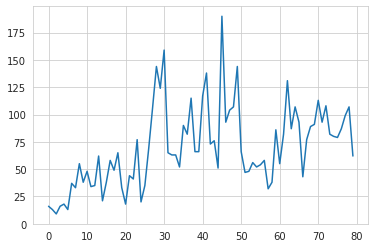

In [ ]:
base_conf = {
    "env": "CartPole-v1",
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -444.70
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -468.90
Episode 40 Reward -500.00 Average Reward -484.30
Episode 50 Reward -411.00 Average Reward -431.20
Episode 60 Reward -500.00 Average Reward -468.70
Episode 70 Reward -500.00 Average Reward -498.60
Episode 80 Reward -290.00 Average Reward -439.80


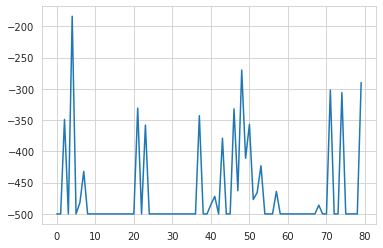

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/160 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -480.70
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -500.00
Episode 50 Reward -330.00 Average Reward -483.00
Episode 60 Reward -500.00 Average Reward -500.00
Episode 70 Reward -500.00 Average Reward -500.00
Episode 80 Reward -500.00 Average Reward -500.00
Episode 90 Reward -500.00 Average Reward -500.00
Episode 100 Reward -500.00 Average Reward -480.90
Episode 110 Reward -500.00 Average Reward -500.00
Episode 120 Reward -500.00 Average Reward -500.00
Episode 130 Reward -500.00 Average Reward -500.00
Episode 140 Reward -500.00 Average Reward -500.00
Episode 150 Reward -284.00 Average Reward -414.90
Episode 160 Reward -500.00 Average Reward -497.00


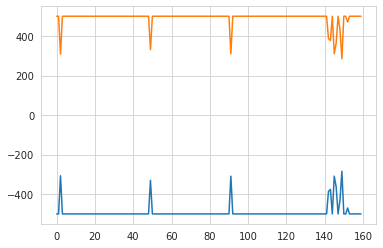

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": np.inf,
    "lr": 1e-3,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 160,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)
plt.plot(sn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -500.00
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -500.00
Episode 50 Reward -500.00 Average Reward -500.00
Episode 60 Reward -500.00 Average Reward -500.00
Episode 70 Reward -500.00 Average Reward -500.00
Episode 80 Reward -500.00 Average Reward -500.00


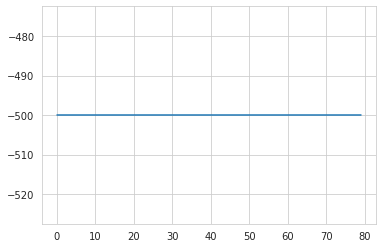

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": 20,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -490.60
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -500.00
Episode 50 Reward -500.00 Average Reward -500.00
Episode 60 Reward -500.00 Average Reward -500.00
Episode 70 Reward -500.00 Average Reward -500.00
Episode 80 Reward -500.00 Average Reward -500.00


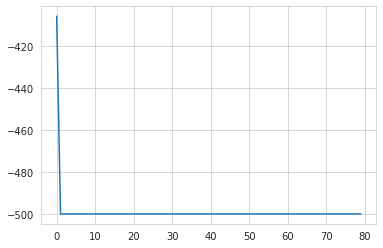

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": 100,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -500.00
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -489.40
Episode 50 Reward -491.00 Average Reward -490.70
Episode 60 Reward -500.00 Average Reward -477.30
Episode 70 Reward -500.00 Average Reward -497.30
Episode 80 Reward -500.00 Average Reward -500.00


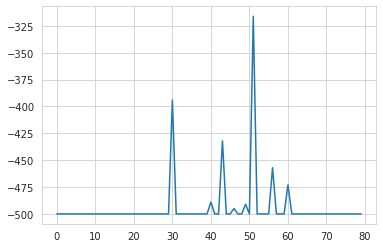

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": (2048, 1024),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -371.00 Average Reward -487.10
Episode 20 Reward -428.00 Average Reward -474.50
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -458.50
Episode 50 Reward -361.00 Average Reward -433.60
Episode 60 Reward -350.00 Average Reward -330.90
Episode 70 Reward -305.00 Average Reward -343.10
Episode 80 Reward -472.00 Average Reward -384.80


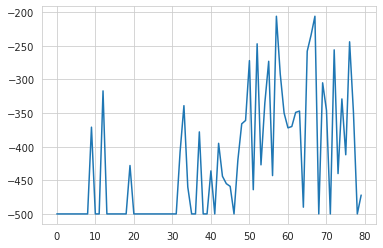

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": np.inf,
    "lr": 1e-3,
    "layer_sizes": (2048, 1024),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

In [ ]:
base_conf = {
    "env": 'Acrobot-v1',
    "h": np.inf, 
    "lr": 1e-4, 
    "layer_sizes": (512, 256),
    "seeds": (10, 12),uuu
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": np.inf,
    "lr": 1e-3,
    "layer_sizes": (2048, 1024),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward -500.00 Average Reward -500.00
Episode 20 Reward -500.00 Average Reward -500.00
Episode 30 Reward -500.00 Average Reward -500.00
Episode 40 Reward -500.00 Average Reward -500.00
Episode 50 Reward -500.00 Average Reward -500.00
Episode 60 Reward -500.00 Average Reward -500.00
Episode 70 Reward -500.00 Average Reward -500.00
Episode 80 Reward -500.00 Average Reward -500.00


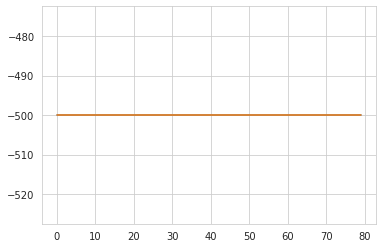

In [ ]:
base_conf = {
    "env": "Acrobot-v1",
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)
plt.plot(sn)

Ep:   0%|          | 0/80 [00:00<?, ?it/s]

Episode 10 Reward 0.00 Average Reward 0.00
Episode 20 Reward 0.00 Average Reward 0.00
Episode 30 Reward 0.00 Average Reward 0.00
Episode 40 Reward 0.00 Average Reward 0.00
Episode 50 Reward 0.00 Average Reward 0.00
Episode 60 Reward 0.00 Average Reward 0.00
Episode 70 Reward 0.00 Average Reward 0.00
Episode 80 Reward 0.00 Average Reward 0.00


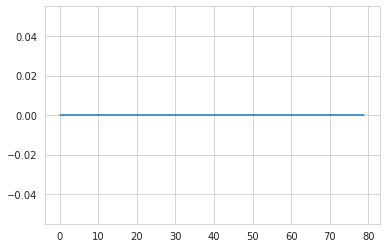

In [ ]:
base_conf = {
    "env": "MountainCar-v0",
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": (1024, 512),
    "seeds": (10, 12),
    "episodes": 80,
}

tn, rn, sn = run_agent(Params(**base_conf), ret=True)
plt.plot(rn)

## Run Set 2

In [ ]:
# Abhiyaan ac
conf4 = {
    "env": ("MountainCar-v0",),
    "h": (
        1,
        30,
        np.inf,
    ),
    "lr": (1e-5, 1e-4, 1e-3),
    "layer_sizes": (
        [2048, 1024],
        [1024, 512],
    ),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
    "episodes": (400,),
}

run_series(conf4, ep_max=200)

In [ ]:
# me19b177 ac
conf4 = {
    "env": ("Acrobot-v1",),
    "h": (
        1,
        10,
        30,
        np.inf,
    ),
    "lr": (1e-5, 1e-4, 1e-3),
    "layer_sizes": (
        [2048, 1024],
        [1024, 512],
    ),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
    "episodes": (200,),
}

run_series(conf4)

In [ ]:
# anudeep ac
conf4 = {
    "env": ("CartPole-v1",),
    "h": (
        1,
        10,
        30,
        np.inf,
    ),
    "lr": (1e-5, 1e-4, 1e-3),
    "layer_sizes": (
        [2048, 1024],
        [1024, 512],
    ),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
    "episodes": (200,),
}

run_series(conf4)

In [ ]:
# suraj ac
conf4 = {
    "env": ("CartPole-v1",),
    "h": (
        1,
        np.inf,
    ),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (55, 21),
        (17, 31),
    ),
    "episodes": (2000,),
}

run_series(conf4)

Running 4 configs


Conf:   0%|          | 0/4 [00:00<?, ?it/s]

Ep:   0%|          | 0/2000 [00:00<?, ?it/s]

Conf:  25%|██▌       | 1/4 [59:48<2:59:26, 3588.76s/it]

Ep:   0%|          | 0/2000 [00:00<?, ?it/s]

Conf:  50%|█████     | 2/4 [2:21:47<2:25:42, 4371.30s/it]

Ep:   0%|          | 0/2000 [00:00<?, ?it/s]

Conf:  75%|███████▌  | 3/4 [2:37:32<46:46, 2806.68s/it]  

Ep:   0%|          | 0/2000 [00:00<?, ?it/s]

Conf: 100%|██████████| 4/4 [2:48:39<00:00, 2529.76s/it]

done


In [ ]:
# suraj ac
conf4 = {
    "env": ("Acrobot-v1",),
    "h": (np.inf,),
    "lr": (1e-44,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (55, 21),
        (17, 31),
    ),
    "episodes": (5000,),
}

run_series(conf4)

Running 2 configs


Conf:   0%|          | 0/2 [00:00<?, ?it/s]

Ep:   0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# suraj ac
conf4 = {
    "env": ("MountainCar-v0",),
    "h": (np.inf,),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (55, 21),
        (17, 31),
    ),
    "episodes": (5000,),
}

run_series(conf4)

In [ ]:
# suraj ac
conf4 = {
    "env": ("MountainCar-v0",),
    "h": (np.inf,),
    "lr": (1e-3,),
    "layer_sizes": ([2048, 1024],),
    "seeds": ((9, 28),),
    "episodes": (1000,),
}

run_series(conf4)

In [ ]:
# suraj ac
conf4 = {
    "env": ("MountainCar-v0",),
    "h": (np.inf,),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (55, 21),
        (17, 31),
    ),
    "episodes": (500,),
}

run_series(conf4, reset_graph=True)

Running 2 configs


Conf:   0%|          | 0/2 [00:00<?, ?it/s]

Ep:   0%|          | 0/500 [00:00<?, ?it/s]

Conf:  50%|█████     | 1/2 [27:14<27:14, 1634.21s/it]

Ep:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
import ctypes

libc = ctypes.CDLL("libc.so.6")  # clearing cache
libc.malloc_trim(0)

1

0

In [ ]:
# suraj ac
conf4 = {
    "env": ("MountainCar-v0",),
    "h": (50,),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (55, 21),
        (17, 31),
    ),
    "episodes": (500,),
}

run_series(conf4, reset_graph=100)

## Run Set 3

### H-Values

In [ ]:
base_conf = {
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
tn, rn, sn = run_agent(Params(**base_conf), ret=True, ep_max=80)
plt.plot(rn)

In [ ]:
base_conf = {
    "h": 2,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
tn, rn, sn = run_agent(Params(**base_conf), ret=True, ep_max=80)
plt.plot(rn)

In [ ]:
base_conf = {
    "h": 10,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
tn, rn, sn = run_agent(Params(**base_conf), ret=True, ep_max=80)
plt.plot(rn)

In [ ]:
plt.plot(sn)

In [ ]:
base_conf = {
    "h": 2,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 5,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 10,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

### Wide H-Values

In [ ]:
base_conf = {
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 2,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 5,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 10,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

### Other test

In [ ]:
base_conf = {
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": 1,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf), override_to_n=True)

In [ ]:
base_conf = {
    "h": 10,
    "lr": 1e-4,
    "layer_sizes": [2048, 1024],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf))

In [ ]:
base_conf = {
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": [1024, 512],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf), override_to_n=True)

In [ ]:
base_conf = {
    "h": np.inf,
    "lr": 1e-4,
    "layer_sizes": [256, 128],
    "seeds": (10, 12),
}
run_agent(Params(**base_conf), override_to_n=True)

### Network Shape

#### Run the Base Configs

In [ ]:
base_configs = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([1024, 512],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(base_configs)

In [ ]:
!ls {root_dir}

#### Run a wider network

In [ ]:
wide_configs = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(wide_configs)

#### Run a narrower network

In [ ]:
narrow_configs = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([512, 256],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(narrow_configs)

#### Run on a Deeper

In [ ]:
deep_config = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([1024, 512, 512],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(deep_config)

#### Run on a Deeper Narrow

In [ ]:
deep_nar_config = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([512, 256, 256],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(deep_nar_config)

#### Very Shallow

In [ ]:
shallowest_conf = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": (
        [
            1024,
        ],
    ),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(shallowest_conf)

### Learning Rate

For this set of runs, the number of episodes has been reduced to 125

In [ ]:
conf1 = {
    "h": (1,),
    "lr": (1e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(conf1, ep_max=200)

In [ ]:
conf2 = {
    "h": (1,),
    "lr": (5e-4,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(conf2, ep_max=200)

In [ ]:
conf3 = {
    "h": (1,),
    "lr": (1e-3,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(conf3, ep_max=200)

In [ ]:
conf4 = {
    "h": (1,),
    "lr": (1e-5,),
    "layer_sizes": ([2048, 1024],),
    "seeds": (
        (10, 12),
        (55, 21),
        (17, 31),
        (21, 3),
        (50, 40),
        (23, 33),
        (71, 93),
        (99, 9),
        (0, 0),
        (77, 77),
    ),
}

run_series(conf4, ep_max=200)